In [200]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [397]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [201]:
import configs

In [203]:
lstm_gen = configs.config_generator('CharLSTM')

In [204]:
lstm_confs = configs.get_x_configs('CharLSTM', 100)

In [205]:
import pandas as pd
df = pd.DataFrame(lstm_confs)

In [206]:
df.optimizer.value_counts()

SGD        40
RMSProp    32
Adam       28
Name: optimizer, dtype: int64

In [207]:
df.lstm_layer.value_counts()

2    53
1    47
Name: lstm_layer, dtype: int64

In [208]:
df.batch_size.value_counts()

30    37
10    36
20    27
Name: batch_size, dtype: int64

In [212]:
cnn_confs = configs.get_x_configs('CharCNN', 100)

In [213]:
import pandas as pd
cdf = pd.DataFrame(cnn_confs)

In [214]:
cdf.optimizer.value_counts()

SGD        34
Adam       34
RMSProp    32
Name: optimizer, dtype: int64

In [215]:
cdf.lstm_layer.value_counts()

1    52
2    48
Name: lstm_layer, dtype: int64

In [216]:
cdf.batch_size.value_counts()

30    36
20    32
10    32
Name: batch_size, dtype: int64

In [217]:
import os

In [218]:
import json

max_digits = len(str(len(lstm_confs)))
full_confs = []
for i, conf in enumerate(lstm_confs):
    fc = configs.create_conf_file(f'hp_search/conf/morph_charlstm.{str(i).zfill(max_digits)}.conf', 
                             f'hp_search/models/morph_charlstm.{str(i).zfill(max_digits)}.model', 
                             'gold_morpheme', 
                             conf, 
                             'alt_tok_yap_ft_sg')
    full_confs.append(fc)

for i, fc in enumerate(full_confs):
    with open( f'hp_search/conf_json/morph_charlstm.{str(i).zfill(max_digits)}.json', 'w') as of:
        of.write(json.dumps(fc))

In [219]:
max_digits = len(str(len(cnn_confs)))
full_confs = []
for i, conf in enumerate(cnn_confs):
    fc = configs.create_conf_file(f'hp_search/conf/morph_charcnn.{str(i).zfill(max_digits)}.conf', 
                             f'hp_search/models/morph_charcnn.{str(i).zfill(max_digits)}.model', 
                             'gold_morpheme', 
                             conf, 
                             'alt_tok_yap_ft_sg')
    full_confs.append(fc)

for i, fc in enumerate(full_confs):
    with open( f'hp_search/conf_json/morph_charcnn.{str(i).zfill(max_digits)}.json', 'w') as of:
        of.write(json.dumps(fc))

## Token

In [220]:
max_digits = len(str(len(lstm_confs)))
full_confs = []
for i, conf in enumerate(lstm_confs):
    fc = configs.create_conf_file(f'hp_search/conf/token_charlstm.{str(i).zfill(max_digits)}.conf', 
                             f'hp_search/models/token_charlstm.{str(i).zfill(max_digits)}.model', 
                             'gold_token_bioes', 
                             conf, 
                             'alt_tok_tokenized_ft_sg')
    full_confs.append(fc)

for i, fc in enumerate(full_confs):
    with open( f'hp_search/conf_json/token_charlstm.{str(i).zfill(max_digits)}.json', 'w') as of:
        of.write(json.dumps(fc))

In [221]:
max_digits = len(str(len(cnn_confs)))
full_confs = []
for i, conf in enumerate(cnn_confs):
    fc = configs.create_conf_file(f'hp_search/conf/token_charcnn.{str(i).zfill(max_digits)}.conf', 
                             f'hp_search/models/token_charcnn.{str(i).zfill(max_digits)}.model', 
                             'gold_token_bioes', 
                             conf, 
                             'alt_tok_tokenized_ft_sg')
    full_confs.append(fc)

for i, fc in enumerate(full_confs):
    with open( f'hp_search/conf_json/token_charcnn.{str(i).zfill(max_digits)}.json', 'w') as of:
        of.write(json.dumps(fc))

## Check results

In [631]:
len(cnn_confs[0]), len(lstm_confs[0])

(24, 24)

In [352]:
lstm_confs[0]

{'word_seq_feature': 'LSTM',
 'word_emb_dim': 300,
 'char_emb_dim': 30,
 'iteration': 100,
 'bilstm': True,
 'norm_word_emb': False,
 'norm_char_emb': False,
 'ave_batch_loss': False,
 'l2': 1e-08,
 'lstm_layer': 2,
 'batch_size': 10,
 'number_normalized': False,
 'optimizer': 'SGD',
 'nbest': 1,
 'char_seq_feature': 'LSTM',
 'use_char': True,
 'use_crf': True,
 'char_hidden_dim': 50,
 'hidden_dim': 200,
 'dropout': 0.5,
 'cnn_layer': 8,
 'learning_rate': 0.015,
 'lr_decay': 0.05,
 'momentum': 0}

In [625]:
import re
DEV_RES_LINE = re.compile('Dev: .*; acc: (?P<acc>[^,]+), p: (?P<p>[^,]+), r: (?P<r>[^,]+), f: (?P<f>[-\d\.]+)')


res = []
for f in os.scandir('hp_search/logs'):
    if f.name.startswith('.ipy'):
        continue
    arch = f.name.split('.')[0]
    unit = arch.split('_')[0]
    conf_num = f.name.split('.')[1]
    matching_conf = cnn_confs[int(conf_num)] if 'cnn' in arch else lstm_confs[int(conf_num)]
    params = { 'arch': arch, 'unit': unit, 'conf_num': conf_num}
    params.update(matching_conf)
    with open(f.path, 'r') as fp:
        i= 0
        for line in fp:
            m = DEV_RES_LINE.match(line)
            if m:
                r = m.groupdict().copy()
                for k, v in r.items():
                    r[k] = float(v)
                r.update(params)
                r['epoch'] = i
                i+=1
                res.append(r)

In [626]:
rdf = pd.DataFrame(res)

In [627]:
erdf = rdf[(rdf.groupby(['conf_num', 'arch']).f.transform(max)==rdf.f) ]
erdf = erdf[(erdf.groupby(['conf_num', 'arch']).epoch.transform(min)==erdf.epoch) ]

In [628]:
erdf.groupby(['conf_num', 'arch']).f.max().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
conf_num,,,,
000,0.7443,0.7904,0.7538,0.7697
001,0.0112,0.0480,NaN,0.0299
002,0.6211,0.5269,0.5855,0.4356
003,0.6352,0.7829,0.5522,0.7383
004,0.7736,0.5486,0.7313,0.6659
...,...,...,...,...
095,0.6712,0.5704,0.6344,0.5282
096,0.6645,0.6187,0.6301,0.5871
097,0.6403,0.0488,0.5876,0.0480


In [629]:
erdf.shape

(387, 32)

In [630]:
erdf.groupby('arch').f.max()

arch
morph_charcnn     0.7736
morph_charlstm    0.7904
token_charcnn     0.7538
token_charlstm    0.7697
Name: f, dtype: float64

In [550]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).conf_num.nunique().unstack()

arch                     morph_charcnn  morph_charlstm  token_charcnn  \
optimizer learning_rate                                                 
Adam      0.0005                     9              17              9   
          0.0010                    13               5             13   
          0.0050                    12               6             12   
RMSProp   0.0050                    11              11             11   
          0.0100                    12               9             12   
          0.0500                     9              12              9   
SGD       0.0100                     8              16              8   
          0.0150                    13               8             13   
          0.0300                    13              16             13   

arch                     token_charlstm  
optimizer learning_rate                  
Adam      0.0005                     17  
          0.0010                      5  
          0.0050                      6  
RMSProp   0.0050                     11  
          0.0100                      9  
          0.0500                     12  
SGD       0.0100                     16  
          0.0150                      8  
          0.0300                     16

In [552]:
erdf[erdf.f>0].groupby(['optimizer', 'learning_rate', 'arch']).conf_num.nunique().unstack()

arch                     morph_charcnn  morph_charlstm  token_charcnn  \
optimizer learning_rate                                                 
Adam      0.0005                     9              17              9   
          0.0010                    13               5             13   
          0.0050                    12               6             12   
RMSProp   0.0050                    11              11             11   
          0.0100                    12               9             12   
          0.0500                     8              12              7   
SGD       0.0100                     7              16              8   
          0.0150                    12               8              9   
          0.0300                    13              16             12   

arch                     token_charlstm  
optimizer learning_rate                  
Adam      0.0005                     17  
          0.0010                      5  
          0.0050                      6  
RMSProp   0.0050                     11  
          0.0100                      9  
          0.0500                     12  
SGD       0.0100                     16  
          0.0150                      8  
          0.0300                     16

In [553]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).f.median().unstack()

arch                     morph_charcnn  morph_charlstm  token_charcnn  \
optimizer learning_rate                                                 
Adam      0.0005               0.61800         0.65610        0.57880   
          0.0010               0.63520         0.63680        0.62760   
          0.0050               0.64150         0.64485        0.59910   
RMSProp   0.0050               0.65110         0.67560        0.59730   
          0.0100               0.62855         0.64080        0.56185   
          0.0500               0.37390         0.53635        0.14040   
SGD       0.0100               0.05520         0.75655        0.04580   
          0.0150               0.04800         0.50425        0.04800   
          0.0300               0.04790         0.33815        0.04800   

arch                     token_charlstm  
optimizer learning_rate                  
Adam      0.0005                0.61420  
          0.0010                0.60000  
          0.0050                0.58950  
RMSProp   0.0050                0.64200  
          0.0100                0.58170  
          0.0500                0.43560  
SGD       0.0100                0.71895  
          0.0150                0.54830  
          0.0300                0.61780

In [554]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).f.max().unstack()

arch                     morph_charcnn  morph_charlstm  token_charcnn  \
optimizer learning_rate                                                 
Adam      0.0005                0.6767          0.6951         0.6452   
          0.0010                0.6901          0.6704         0.6615   
          0.0050                0.6645          0.6835         0.6608   
RMSProp   0.0050                0.6791          0.6962         0.6352   
          0.0100                0.6530          0.6596         0.5974   
          0.0500                0.4304          0.5798         0.3515   
SGD       0.0100                0.7736          0.7900         0.7437   
          0.0150                0.7629          0.7904         0.7538   
          0.0300                0.7478          0.7419         0.6845   

arch                     token_charlstm  
optimizer learning_rate                  
Adam      0.0005                 0.6600  
          0.0010                 0.6495  
          0.0050                 0.6659  
RMSProp   0.0050                 0.6591  
          0.0100                 0.6056  
          0.0500                 0.5340  
SGD       0.0100                 0.7554  
          0.0150                 0.7697  
          0.0300                 0.7269

In [555]:
erdf.groupby(['dropout', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
dropout,,,,
0.1,0.60055,0.60740,0.55585,0.58170
0.3,0.62235,0.65100,0.57275,0.62340
0.5,0.63070,0.64725,0.56665,0.61565


In [559]:
erdf.groupby(['hidden_dim', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
hidden_dim,,,,
50,0.58275,0.61750,0.54485,0.5799
100,0.62915,0.63685,0.57450,0.6028
200,0.63070,0.65820,0.56790,0.6246


In [561]:
erdf.groupby(['lstm_layer', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
lstm_layer,,,,
1,0.62235,0.6570,0.57790,0.6189
2,0.61815,0.6369,0.55585,0.5917


In [593]:
erdf.groupby(['lstm_layer', 'arch']).f.max().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
lstm_layer,,,,
1,0.7736,0.7900,0.7538,0.7554
2,0.7629,0.7904,0.6845,0.7697


In [562]:
erdf.groupby(['optimizer', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
optimizer,,,,
Adam,0.63465,0.63775,0.58965,0.60215
RMSProp,0.62855,0.63385,0.56555,0.57930
SGD,0.04800,0.66155,0.04800,0.66860


In [563]:
erdf[erdf.arch.str.contains('cnn')].groupby(['cnn_layer', 'arch']).f.median().unstack()

arch,morph_charcnn,token_charcnn
cnn_layer,,
2,0.62615,0.58105
4,0.62610,0.56890
8,0.61010,0.53930


In [564]:
erdf[erdf.arch.str.contains('lstm')].groupby(['char_hidden_dim', 'arch']).f.median().unstack()

arch,morph_charlstm,token_charlstm
char_hidden_dim,,
20,0.61870,0.6056
50,0.62940,0.5817
70,0.65755,0.6444


In [581]:
erdf.loc[erdf.char_seq_feature=='CNN', 'char_hidden_dim']=None
erdf.loc[erdf.char_seq_feature=='LSTM', 'cnn_layer']=None

In [591]:
erdf[erdf.optimizer=='SGD'].groupby(['momentum', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
momentum,,,,
0.0,0.2829,0.76175,0.04800,0.72640
0.3,0.0479,0.74150,0.04800,0.70125
0.9,0.0480,0.24035,0.04775,0.30210


In [592]:
erdf[erdf.optimizer=='SGD'].groupby(['lr_decay', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
lr_decay,,,,
0.01,0.04795,0.6360,0.0480,0.62945
0.05,0.04800,0.7296,0.0480,0.65380
0.10,0.38525,0.6464,0.0406,0.67470


In [587]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=False).head(20)[['f', 'p', 'r', 'char_seq_feature', 'lstm_layer', 'batch_size', 
                                                 'optimizer', 'learning_rate', 'lr_decay', 'momentum', 'char_hidden_dim', 'cnn_layer',
                                                 'hidden_dim', 'dropout', 'epoch']]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,optimizer,learning_rate,lr_decay,momentum,char_hidden_dim,cnn_layer,hidden_dim,dropout,epoch
1641,0.7904,0.8286,0.7555,LSTM,2,10,SGD,0.015,0.05,0.0,50,,200,0.5,41
13763,0.7900,0.8588,0.7315,LSTM,1,10,SGD,0.010,0.01,0.0,20,,200,0.5,63
26442,0.7879,0.8512,0.7335,LSTM,2,10,SGD,0.010,0.01,0.3,50,,50,0.3,42
17163,0.7861,0.8578,0.7255,LSTM,2,10,SGD,0.010,0.10,0.0,20,,100,0.3,63
2994,0.7829,0.8394,0.7335,LSTM,1,10,SGD,0.015,0.05,0.0,70,,50,0.1,94
31752,0.7826,0.8311,0.7395,LSTM,1,10,SGD,0.010,0.01,0.3,70,,200,0.3,52
22107,0.7825,0.8139,0.7535,LSTM,1,10,SGD,0.010,0.10,0.0,50,,50,0.3,7
18710,0.7793,0.8419,0.7255,LSTM,1,10,SGD,0.010,0.10,0.3,70,,100,0.1,10
11973,0.7767,0.8229,0.7355,LSTM,1,10,SGD,0.010,0.10,0.0,20,,50,0.1,73
39020,0.7752,0.8322,0.7255,LSTM,2,10,SGD,0.015,0.05,0.3,50,,50,0.3,20


In [589]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=True).head(20)[['f', 'p', 'r', 'char_seq_feature', 'lstm_layer', 'batch_size', 
                                                 'optimizer', 'learning_rate', 'lr_decay', 'momentum', 'char_hidden_dim', 'cnn_layer',
                                                 'hidden_dim', 'dropout', 'epoch']]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,optimizer,learning_rate,lr_decay,momentum,char_hidden_dim,cnn_layer,hidden_dim,dropout,epoch
19400,-1.0000,-1.0000,0.0000,CNN,2,30,SGD,0.015,0.05,0.3,,2,200,0.5,0
33400,-1.0000,0.0000,0.0000,CNN,1,20,SGD,0.010,0.1,0.3,,4,200,0.3,0
23400,-1.0000,-1.0000,0.0000,CNN,2,10,RMSProp,0.050,,,,4,200,0.5,0
31801,0.0005,0.0003,0.0020,CNN,2,30,SGD,0.030,0.1,0,,8,50,0.1,1
1106,0.0112,0.0066,0.0381,CNN,2,30,SGD,0.015,0.01,0.3,,2,100,0.1,6
33103,0.0130,0.0076,0.0441,CNN,1,20,SGD,0.030,0.05,0.3,,2,50,0.5,3
34074,0.0161,0.0092,0.0661,CNN,2,30,SGD,0.030,0.01,0,,8,50,0.3,74
36625,0.0174,0.0098,0.0741,CNN,1,30,SGD,0.015,0.01,0,,2,100,0.1,25
33639,0.0178,0.0101,0.0762,LSTM,2,30,SGD,0.030,0.05,0,20,,50,0.1,39
32497,0.0196,0.5000,0.0100,CNN,2,30,SGD,0.015,0.01,0.3,,2,200,0.1,97


In [588]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=False).head(20)[['f', 'p', 'r', 'char_seq_feature', 'lstm_layer', 'batch_size', 
                                                 'optimizer', 'learning_rate', 'lr_decay', 'momentum', 'char_hidden_dim', 'cnn_layer',
                                                 'hidden_dim', 'dropout', 'epoch']]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,optimizer,learning_rate,lr_decay,momentum,char_hidden_dim,cnn_layer,hidden_dim,dropout,epoch
3396,0.7697,0.8223,0.7234,LSTM,2,10,SGD,0.015,0.05,0.0,50,,200,0.5,96
22958,0.7554,0.8212,0.6994,LSTM,1,10,SGD,0.010,0.01,0.3,70,,200,0.3,58
12395,0.7549,0.8227,0.6974,LSTM,1,10,SGD,0.010,0.01,0.0,20,,200,0.5,95
27068,0.7546,0.8192,0.6994,LSTM,2,10,SGD,0.015,0.05,0.3,50,,50,0.3,68
17649,0.7538,0.8173,0.6994,LSTM,2,10,SGD,0.010,0.01,0.3,50,,50,0.3,49
3150,0.7538,0.8173,0.6994,CNN,1,10,SGD,0.015,0.10,0.0,,8,100,0.5,50
4652,0.7437,0.8244,0.6774,CNN,1,20,SGD,0.010,0.01,0.0,,4,50,0.5,52
18932,0.7435,0.8124,0.6854,LSTM,1,10,SGD,0.010,0.10,0.0,50,,50,0.3,32
15999,0.7433,0.8009,0.6934,CNN,1,10,SGD,0.015,0.01,0.0,,2,50,0.1,99
16748,0.7428,0.7945,0.6974,CNN,1,20,SGD,0.010,0.01,0.3,,2,100,0.3,48


In [590]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=True).head(20)[['f', 'p', 'r', 'char_seq_feature', 'lstm_layer', 'batch_size', 
                                                 'optimizer', 'learning_rate', 'lr_decay', 'momentum', 'char_hidden_dim', 'cnn_layer',
                                                 'hidden_dim', 'dropout', 'epoch']]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,optimizer,learning_rate,lr_decay,momentum,char_hidden_dim,cnn_layer,hidden_dim,dropout,epoch
16300,-1.0000,-1.0000,0.0000,CNN,2,10,RMSProp,0.050,,,,4,200,0.5,0
7100,-1.0000,-1.0000,0.0000,CNN,2,30,SGD,0.015,0.1,0.9,,2,50,0.3,0
14200,-1.0000,-1.0000,0.0000,CNN,2,30,SGD,0.015,0.05,0.3,,2,200,0.5,0
27500,-1.0000,-1.0000,0.0000,CNN,1,10,RMSProp,0.050,,,,2,50,0.1,0
26200,-1.0000,-1.0000,0.0000,CNN,1,30,SGD,0.015,0.01,0,,2,100,0.1,0
19600,-1.0000,-1.0000,0.0000,CNN,2,10,SGD,0.030,0.1,0,,4,200,0.5,0
2500,-1.0000,-1.0000,0.0000,CNN,2,30,SGD,0.015,0.01,0.3,,2,100,0.1,0
23050,0.0031,0.0068,0.0020,CNN,2,30,RMSProp,0.050,,,,2,50,0.3,50
21708,0.0082,0.0052,0.0200,CNN,1,20,SGD,0.030,0.05,0.3,,2,50,0.5,8
16106,0.0126,0.0075,0.0401,CNN,1,20,SGD,0.010,0.05,0.9,,2,50,0.1,6


In [517]:
lstm_confs[0]

{'word_seq_feature': 'LSTM',
 'word_emb_dim': 300,
 'char_emb_dim': 30,
 'iteration': 100,
 'bilstm': True,
 'norm_word_emb': False,
 'norm_char_emb': False,
 'ave_batch_loss': False,
 'l2': 1e-08,
 'lstm_layer': 2,
 'batch_size': 10,
 'number_normalized': False,
 'optimizer': 'SGD',
 'nbest': 1,
 'char_seq_feature': 'LSTM',
 'use_char': True,
 'use_crf': True,
 'char_hidden_dim': 50,
 'hidden_dim': 200,
 'dropout': 0.5,
 'cnn_layer': 8,
 'learning_rate': 0.015,
 'lr_decay': 0.05,
 'momentum': 0}

In [567]:
erdf.groupby('arch').epoch.agg(['median', 'mean', 'std'])

,median,mean,std
arch,,,
morph_charcnn,7,22.13,29.765974
morph_charlstm,21,36.76,35.316783
token_charcnn,4,18.95,25.983824
token_charlstm,18,34.14,34.713261


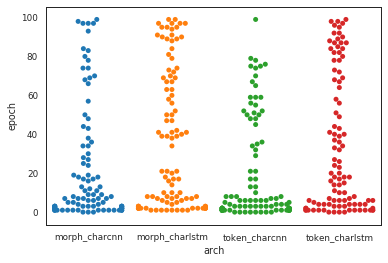

In [519]:
sns.swarmplot(data=rdf[rdf.groupby(['arch', 'conf_num']).f.transform(max)==rdf.f].groupby(['arch', 'conf_num']).epoch.min().reset_index(), x='arch', y='epoch')

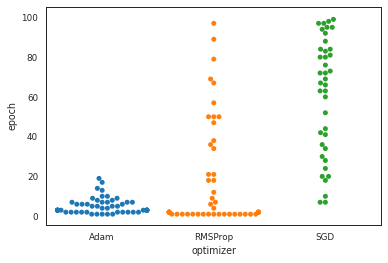

In [520]:
sns.swarmplot(data=rdf[(rdf.f>0.1) & (rdf.groupby(['optimizer', 'conf_num']).f.transform(max)==rdf.f)].groupby(['optimizer', 'conf_num']).epoch.min().reset_index(), x='optimizer', y='epoch')

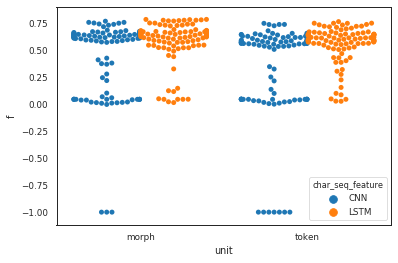

In [573]:
sns.swarmplot(data=erdf.groupby(['char_seq_feature', 'unit','conf_num']).f.max().reset_index(), x='unit', y='f', hue='char_seq_feature', split=True)


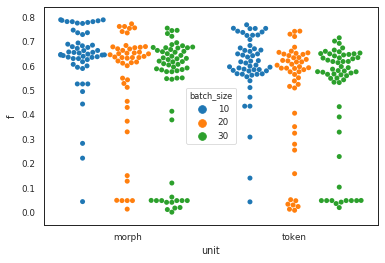

In [522]:
sns.swarmplot(data=rdf[rdf.f>0].groupby(['conf_num', 'unit','batch_size']).f.max().reset_index(), x='unit', y='f', hue='batch_size', split=True)


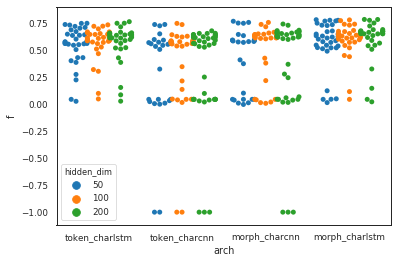

In [598]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='hidden_dim', split=True)


/home/nlp/danb/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


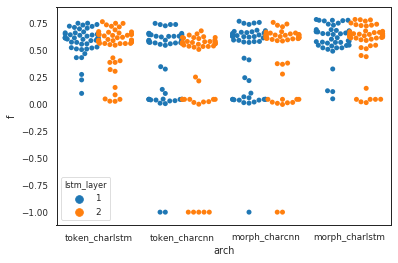

In [594]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='lstm_layer', split=True)


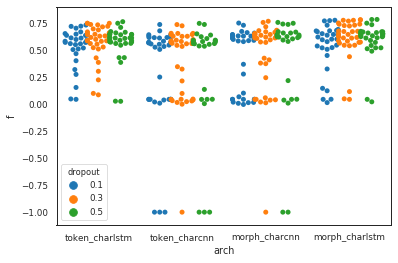

In [595]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='dropout', split=True)


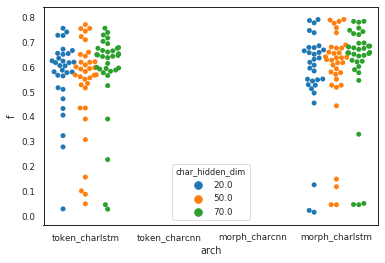

In [596]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='char_hidden_dim', split=True)

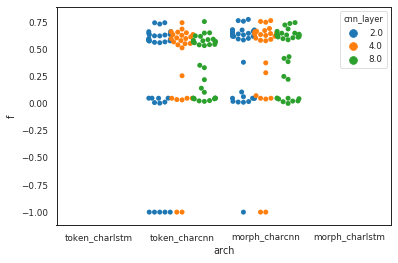

In [597]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='cnn_layer', split=True)

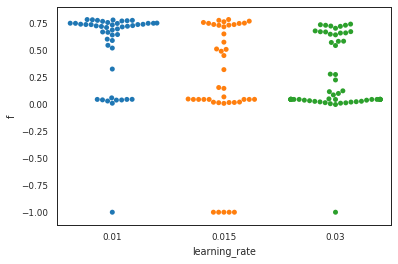

In [605]:
sns.swarmplot(data=erdf[erdf.optimizer=='SGD'], x='learning_rate', y='f', split=True)

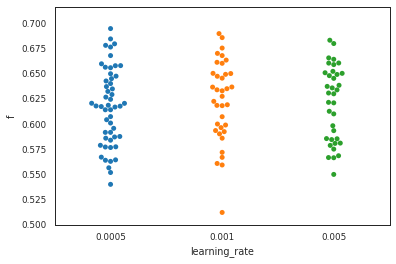

In [609]:
sns.swarmplot(data=erdf[erdf.optimizer=='Adam'], x='learning_rate', y='f', split=True)

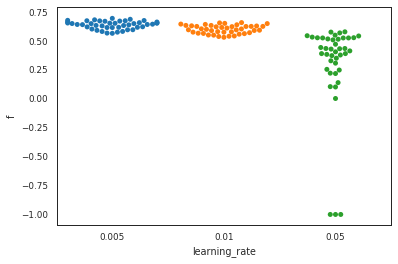

In [611]:
sns.swarmplot(data=erdf[erdf.optimizer=='RMSProp'], x='learning_rate', y='f', split=True)

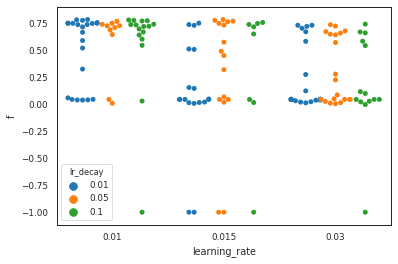

In [612]:
sns.swarmplot(data=erdf[erdf.optimizer=='SGD'], x='learning_rate', y='f', hue='lr_decay', split=True)

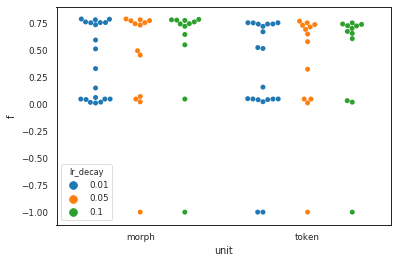

In [615]:
sns.swarmplot(data=erdf[(erdf.optimizer=='SGD') & (erdf.learning_rate<0.03)], x='unit', y='f', hue='lr_decay', split=True)

In [618]:
x = 7
int(x/2)

3

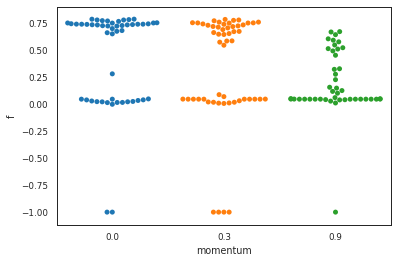

In [604]:
sns.swarmplot(data=erdf[erdf.optimizer=='SGD'], x='momentum', y='f', split=True)

In [571]:
erdf.groupby('arch').apply(lambda x: x.sort_values('f', ascending=False).head(2)).T

arch               morph_charcnn                 morph_charlstm  \
                           1784           30830           1641    
acc                       0.9659         0.9622          0.9679   
p                         0.8235         0.7856          0.8286   
r                         0.7295         0.7415          0.7555   
f                         0.7736         0.7629          0.7904   
arch               morph_charcnn  morph_charcnn  morph_charlstm   
unit                       morph          morph           morph   
conf_num                     004            061             000   
word_seq_feature            LSTM           LSTM            LSTM   
word_emb_dim                 300            300             300   
char_emb_dim                  30             30              30   
iteration                    100            100             100   
bilstm                      True           True            True   
norm_word_emb              False          False           False   
norm_char_emb              False          False           False   
ave_batch_loss             False          False           False   
l2                         1e-08          1e-08           1e-08   
lstm_layer                     1              2               2   
batch_size                    20             20              10   
number_normalized          False          False           False   
optimizer                    SGD            SGD             SGD   
nbest                          1              1               1   
char_seq_feature             CNN            CNN            LSTM   
use_char                    True           True            True   
use_crf                     True           True            True   
char_hidden_dim               20             50              50   
hidden_dim                    50             50             200   
dropout                      0.3            0.5             0.5   
cnn_layer                      2              4               8   
learning_rate               0.01          0.015           0.015   
epoch                         84             30              41   
lr_decay                    0.05            0.1            0.05   
momentum                       0            0.3               0   

arch                               token_charcnn                 \
                            13763          3150           4652    
acc                        0.9665         0.9635         0.9621   
p                          0.8588         0.8173         0.8244   
r                          0.7315         0.6994         0.6774   
f                            0.79         0.7538         0.7437   
arch               morph_charlstm  token_charcnn  token_charcnn   
unit                        morph          token          token   
conf_num                      026            000            009   
word_seq_feature             LSTM           LSTM           LSTM   
word_emb_dim                  300            300            300   
char_emb_dim                   30             30             30   
iteration                     100            100            100   
bilstm                       True           True           True   
norm_word_emb               False          False          False   
norm_char_emb               False          False          False   
ave_batch_loss              False          False          False   
l2                          1e-08          1e-08          1e-08   
lstm_layer                      1              1              1   
batch_size                     10             10             20   
number_normalized           False          False          False   
optimizer                     SGD            SGD            SGD   
nbest                           1              1              1   
char_seq_feature             LSTM            CNN            CNN   
use_char                     True           True           True   
use_crf                      True           Tr

In [525]:
rdf[rdf.groupby('arch').f.transform(max)==rdf.f].sort_values('f', ascending=False).T

,1641,1784,3396,3150
acc,0.9679,0.9659,0.9661,0.9635
p,0.8286,0.8235,0.8223,0.8173
r,0.7555,0.7295,0.7234,0.6994
f,0.7904,0.7736,0.7697,0.7538
arch,morph_charlstm,morph_charcnn,token_charlstm,token_charcnn
unit,morph,morph,token,token
conf_num,000,004,000,000
word_seq_feature,LSTM,LSTM,LSTM,LSTM
word_emb_dim,300,300,300,300
char_emb_dim,30,30,30,30


## TODO:
1. create more random configs (we will take them sequencially for order's sake)
1. ~~run more in another server~~
1. ~~match confs and results~~
1. initial analysis and maybe drop and add some HPs